### Neshyba 2023


# Particle-on-a-sphere

## Introduction

### The Laplacian for spherical coordinates at fixed radius

The Schrödinger equation, of course, is given by

$$
H\psi=E\psi \ \ \ \ (1)
$$

where $H$ consists of a potential and a kinetic term,

$$
H = V(x,y,z) + {-\hbar^2 \over 2 m} \nabla^2 \ \ \ \ (2)
$$

There's some very cool kron stuff that shows how to construct the laplacian in three dimensions: https://math.stackexchange.com/questions/3120948/discretization-matrix-for-3d-poisson-equation. 

We'd like to implement this in position space (i.e., $\theta$ and $\phi$ space, since doing so will

- Give us a comparison when we go for analytical solutions to this system.
- Give us a pathway to tacking more complex systems, like a rotating molecule subjected to an external electric field, which don't have analytical solutions.

In [11]:
import pint; from pint import UnitRegistry; AssignQuantity = UnitRegistry(system='atomic').Quantity
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt
import PchemLibrary as PL
import plotly.graph_objects as go
import scipy.linalg as spla
%matplotlib notebook

In [12]:
# Quantum constants
hbar = AssignQuantity(1,'atomic_unit_of_time * hartree'); print(hbar)
h = hbar*2*np.pi; print(h)
m = AssignQuantity(1,'atomic_unit_of_mass'); print(m)

1 atomic_unit_of_time * hartree
6.283185307179586 atomic_unit_of_time * hartree
1 electron_mass


In [13]:
# Define the space and create the (identical) x, y, and z spaces
nsteps = 19
L = 2
a = 2*L
x = np.linspace(-L,L,nsteps)
dx = x[1]-x[0]

In [14]:
# Define the kinetic energy term
def kron3(X,Y,Z):
    return np.kron(X,np.kron(Y,Z))

Ax =(-2.0*np.diag(np.ones(nsteps))+np.diag(np.ones(nsteps-1),1)+np.diag(np.ones(nsteps-1),-1))/dx**2
I = np.diag(np.ones(nsteps))
KE = -.5*(kron3(I,I,Ax) + kron3(I,Ax,I) + kron3(Ax,I,I))
print(np.shape(Ax), np.shape(KE))
print(Ax[0:4,0:4])

(19, 19) (6859, 6859)
[[-40.5   20.25   0.     0.  ]
 [ 20.25 -40.5   20.25   0.  ]
 [  0.    20.25 -40.5   20.25]
 [  0.     0.    20.25 -40.5 ]]


<IPython.core.display.Javascript object>


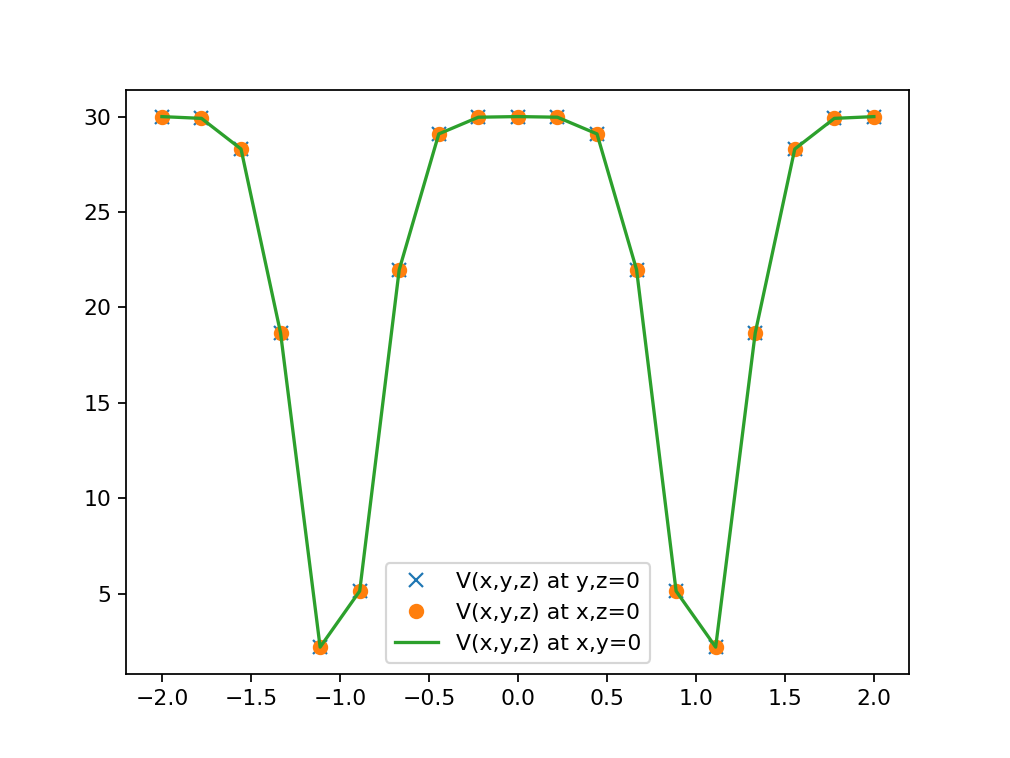

In [15]:
def getVofr(x,y,z,r0,V0=10):
    r2 = x**2 + y**2 + z**2
    r = np.sqrt(r2)
    sharpnessfactor = .1
    result1 = r**.5*np.exp(-(r-r0)**2/sharpnessfactor)
    result2 = 1 - result1 / np.max(result1)
    result3 = result2*V0
    return result3, r

# Add a thin shell at some desired radius
r0 = 1
ygrid,xgrid,zgrid = np.meshgrid(x,x,x) # meshgrid puts x and y in the opposite order of expected!
Vofr, r = getVofr(xgrid,ygrid,zgrid,r0,30)

imid = int(nsteps/2)
plt.figure()
plt.plot(xgrid[:,imid,imid],Vofr[:,imid,imid],'x',label='V(x,y,z) at y,z=0')
plt.plot(ygrid[imid,:,imid],Vofr[imid,:,imid],'o',label='V(x,y,z) at x,z=0')
plt.plot(zgrid[imid,imid,:],Vofr[imid,imid,:],'-',label='V(x,y,z) at x,y=0')
plt.legend()

In [16]:
# Construct the matrix representation of the potential energy
A2 = Vofr; print(np.shape(A2))
A2 = np.reshape(Vofr,nsteps**3); print(np.shape(A2))
PE = np.diag(A2)

(19, 19, 19)
(6859,)


In [17]:
# Construct the Hamiltonian
H = KE + PE

In [18]:
# Diagonalize 
Epsi,psi = spla.eigh(H)

<IPython.core.display.Javascript object>


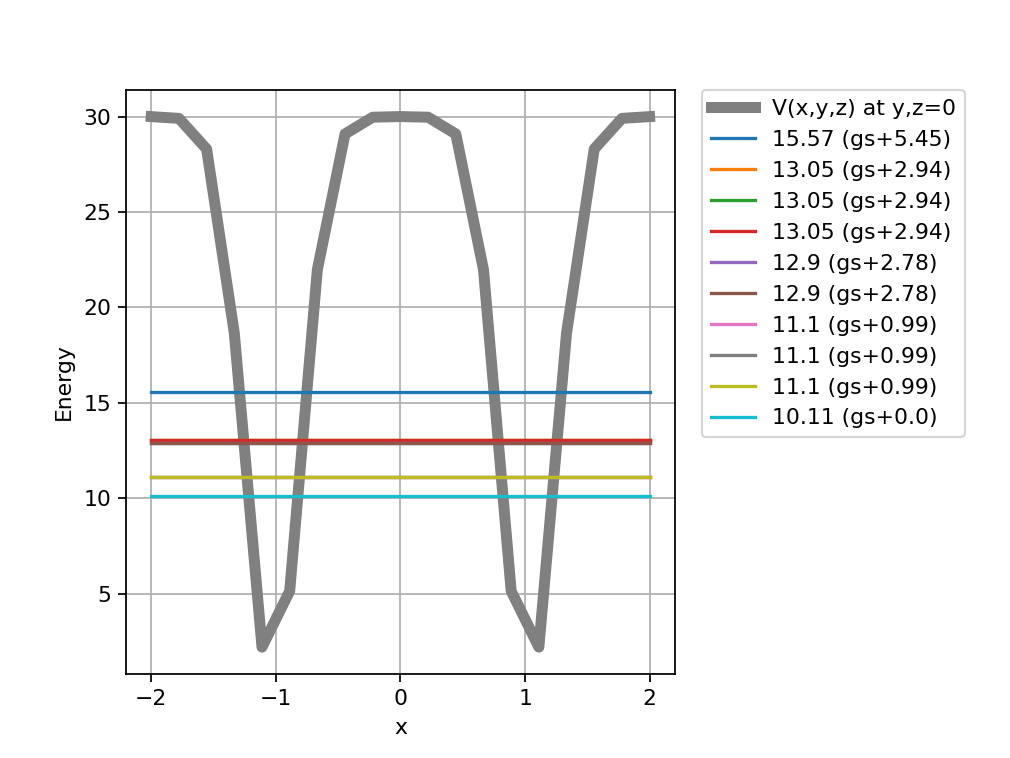

Here are the state index, state energy, and energy above 1st state:
9 15.57 5.45
8 13.05 2.94
7 13.05 2.94
6 13.05 2.94
5 12.9 2.78
4 12.9 2.78
3 11.1 0.99
2 11.1 0.99
1 11.1 0.99
0 10.11 0.0
Energies & degeneracies according to https://www.physik.unibe.ch/unibe/portal/fak_naturwis/b_paw/a_fphyast/content/e41821/e41822/e140946/e148658/e875197/files902624/circle_ger.pdf
0 0.0 1
1 1.0 3
2 3.0 5
3 6.0 7


In [36]:
# Compute energy differences
Epsi_above0 = Epsi-Epsi[0]

# Visualize the energies agains the potential energy
f=plt.figure()
ax=f.add_subplot(111)

n = 10
plt.plot(x,Vofr[:,imid,imid],'gray',linewidth=5,label='V(x,y,z) at y,z=0')
print('Here are the state index, state energy, and energy above 1st state:')
for i in range(n-1,-1,-1):
    thisEnergyDifference = round(Epsi_above0[i],2)
    thisEnergy = round(Epsi[i],2)
    print(i, thisEnergy, thisEnergyDifference)
    plt.plot( [x[0],x[-1]], [Epsi[i],Epsi[i]], label=str(thisEnergy)+' (gs+'+str(thisEnergyDifference)+')')
plt.grid('True')
plt.xlabel('x')
plt.ylabel('Energy')

# Trying to put the legend to one side
L=plt.legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
box=ax.get_position()
ax.set_position([box.x0,box.y0,0.7*box.width,box.height])


# Compare to energies and degeneracies according to an analytical approach
print('Energies & degeneracies according to https://www.physik.unibe.ch/unibe/portal/fak_naturwis/b_paw/a_fphyast/content/e41821/e41822/e140946/e148658/e875197/files902624/circle_ger.pdf')
for l in range(4):
    print(l, l*(l+1)/2, 2*l+1)

<IPython.core.display.Javascript object>


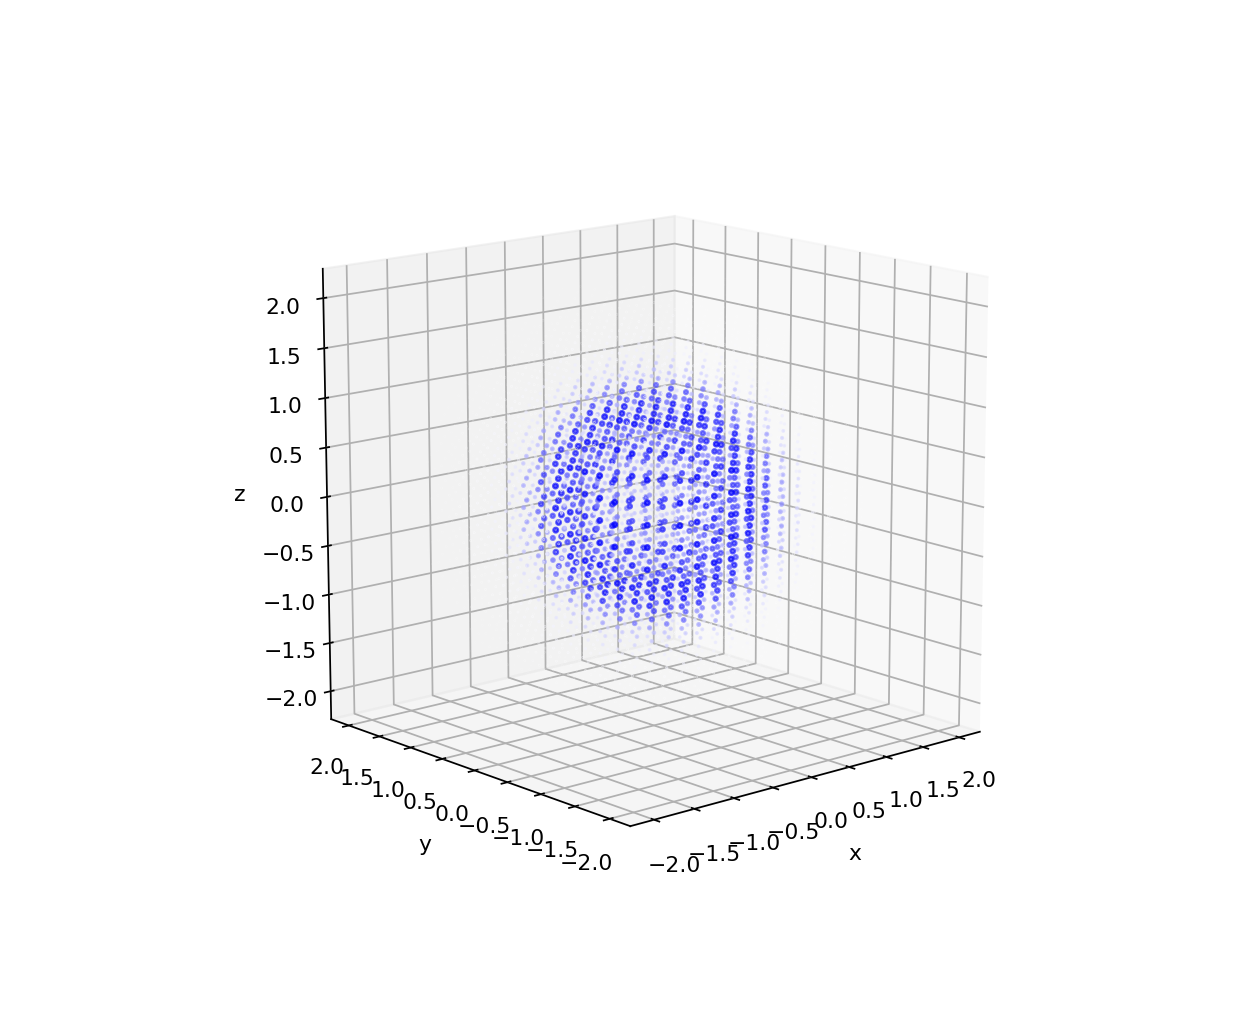

<IPython.core.display.Javascript object>


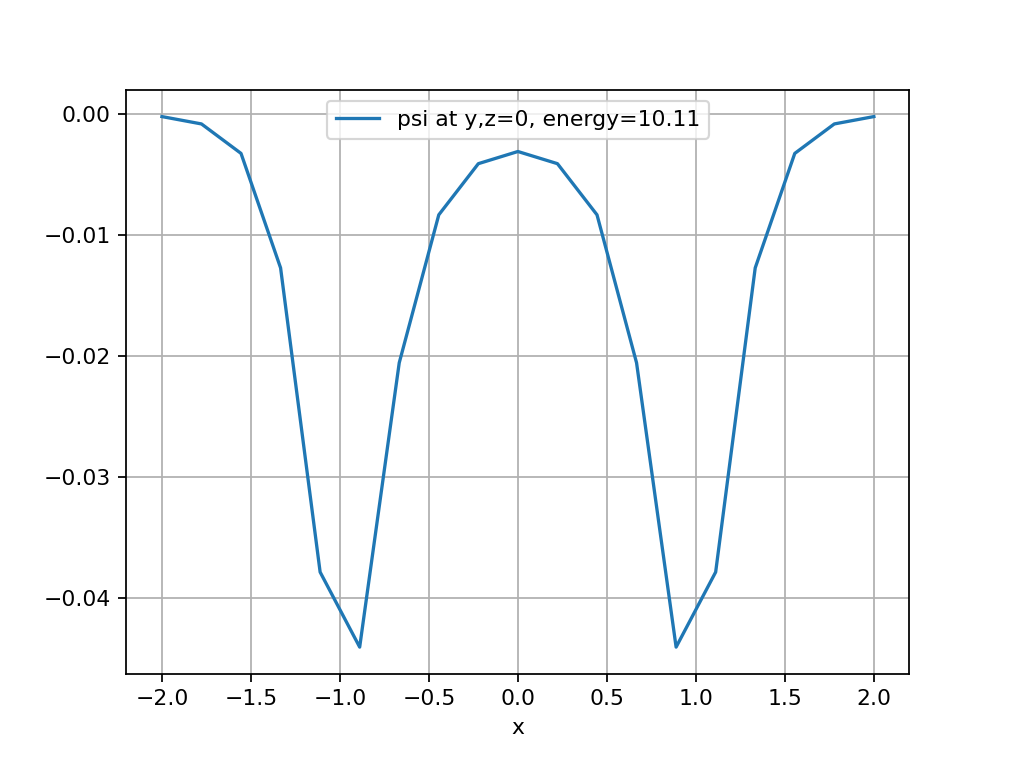

In [20]:
# Visualize a state
thisindex = 0
thispsi = psi[:,thisindex]
thisEpsi = round(Epsi[thisindex],2)
symbolsize = 100
fig = plt.figure('2,1,1')
ax = fig.add_subplot(projection='3d')
scale = np.max([np.max(thispsi),-np.min(thispsi)])
aspect_ratio = 1
ax.set_box_aspect(aspect = (aspect_ratio,1,1))
ax.scatter(xgrid,ygrid,zgrid, s=np.abs(thispsi)*symbolsize, c=np.real(thispsi), vmin=-scale, vmax=scale, cmap="bwr")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.figure()
thispsi_reshaped = np.reshape(thispsi,[nsteps,nsteps,nsteps])
plt.plot(xgrid[:,imid,imid],thispsi_reshaped[:,imid,imid],label='psi at y,z=0, energy='+str(thisEpsi))
plt.xlabel('x')
plt.grid(True)
plt.legend()

### Refreshing and saving your code
1. Use the dropdown menu Kernel/Restart
2. Use the dropdown menu Cell/Run All Above
3. Under the "File" dropdown menu item in the upper left is a disk icon. Press it now to save your work (you can, do this at any time as you're working on an assignment, actually).

### Validating
This step will help ensure that you didn't miss something (although it's not a guarantee). Find the "Validate" button and press it. If there are any errors or warnings, fix them.

### Finishing up
Assuming all this has gone smoothly, carry out three more steps (but read this carefully before starting):
1. Close this notebook using the "File/Close and Halt" dropdown menu
1. Using the Assignments tab, submit this notebook
1. Press the Logout tab of the Home Page